In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from scipy.special import logsumexp

### Model

$$X_t = \phi X_{t-1} + W_t$$
$$Y_t = V_tX_t$$

$$V_t \sim N(1, 0.1^2)$$
$$W_t \sim N(0, 1)$$

In [24]:
def simulate(T, phi, seed=0):
    np.random.seed(seed)
    x = np.zeros(T)    
    x[0] = np.random.normal()
    
    for t in range(1, T):
        x[t] = np.random.normal(loc=phi*x[t-1])
    y = x * np.random.normal(loc=1,scale=0.1,size=T)

    return x, y

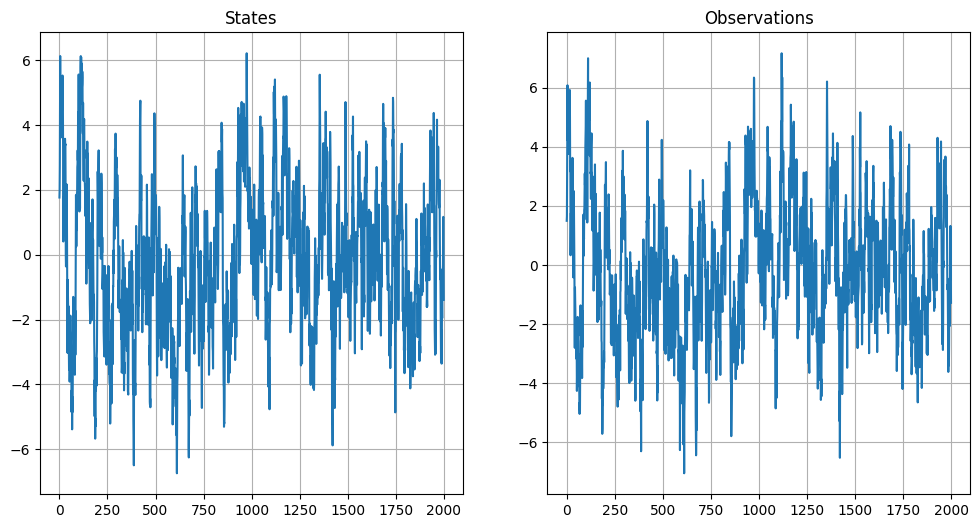

In [25]:
T= 2000 # time steps
phi = 0.9 
states, observations = simulate(T, phi)
fig, ax = plt.subplots(figsize=(12, 6),ncols=2, nrows=1)
ax[0].plot(states)
ax[0].set_title('States')
ax[0].grid()
ax[1].plot(observations)
ax[1].set_title('Observations')
ax[1].grid()

Below is the code implementing the parameter estimation scheme

In [11]:
def q(y, x):
    return st.norm.pdf(y, loc=x, scale=0.1)


def log_q(y, x):
    return st.norm.logpdf(y, loc=x, scale=0.1)


def p(x_2, x_1, phi):
    return st.norm.pdf(
        x_2,
        loc=phi * x_1,
    )


def resample_propogate_log(N, observation, particles, phi):
    logw = log_q(observation, particles)
    logw -= logsumexp(logw)
    w = np.exp(logw)
    s = np.sum(w)
    if s == 0 or not np.isfinite(s):
        w = np.ones(N) / N
    else:
        w /= s
    resamples = np.random.choice(a=particles, size=N, p=w)
    particles = np.random.normal(
        loc=phi * resamples,
    )
    return particles


def d_phi(phi, x_2, x_1):  # dphi/dp = d(logphi)/dphi * phi
    return p(x_2, x_1, phi) * ((x_2 - phi * x_1) * x_1)


def a(n):  # step size
    return 1 / (n + 1)


def estimate_params(T, observations, N=1000):
    # initial config
    phi = 0.1
    particles = np.random.normal(loc=0, size=N)
    weights = 1 / N * np.ones(N)
    # weights = np.zeros(N)

    param_evolution = [phi]
    for j in range(T - 1):
        observation = observations[j]
        next_particles = resample_propogate_log(N, observation, particles, phi)
        next_observation = observations[j + 1]
        new_weights = np.empty(N)
        for i in range(N):
            normaliser = np.sum(
                (p(next_particles[i], particles, phi) * q(observation, particles))
            )
            if normaliser == 0:
                continue
            new_weights[i] = (
                np.sum(
                    d_phi(phi, next_particles[i], particles) * q(observation, particles)
                )
                + np.sum(
                    p(next_particles[i], particles, phi)
                    * q(observation, particles)
                    * weights
                )
            ) / normaliser

        new_weights = new_weights - np.mean(new_weights)
        normaliser = np.sum(q(next_observation, next_particles))
        if normaliser != 0:  # normaliser == 0 iff all probabilities are zero
            phi += (
                a(j)
                * np.sum(q(next_observation, next_particles) * new_weights)
                / normaliser
            )
            phi = min(max(phi, 0.001), 2)

        weights = new_weights
        param_evolution.append(phi)

        print(f"Iteration {j + 1}/{T - 1} phi:{phi})")

        particles = next_particles
    return param_evolution

In [2]:
def plot_param_estimation(guesses):
    guesses = np.array(guesses)

    phis = guesses

    fig, ax = plt.subplots()
    ax.plot(phis, label="phi", color="green")
    ax.hlines(y=phi, xmin=0, xmax=len(phis),label="true phi", linestyle="dashed", color="red")
    fig.legend()
    ax.grid()
    fig.set_figheight(6)
    fig.set_figwidth(10)

In [ ]:
guesses = estimate_params(T=500, observations=observations, N=1000)

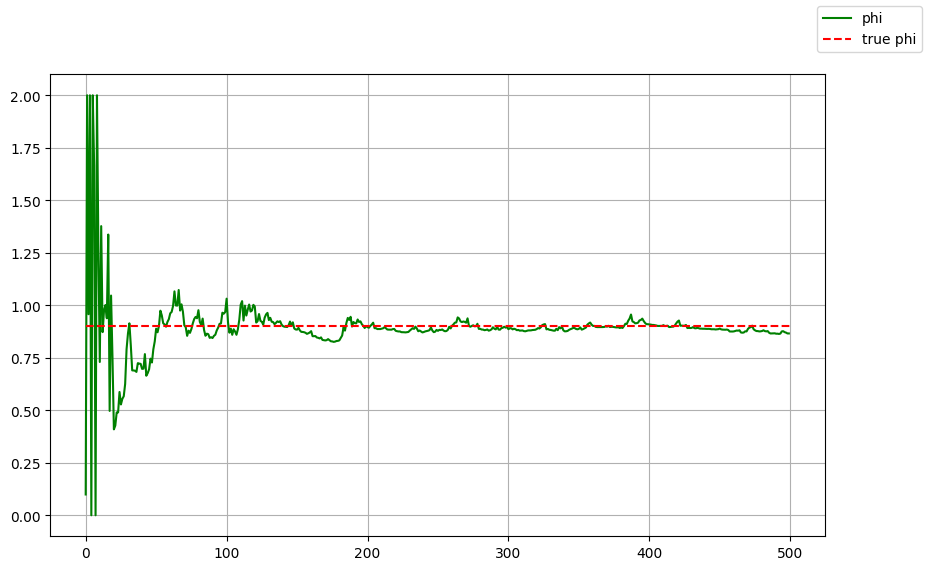

In [12]:
plot_param_estimation(guesses)

Below is the vectorised code, created with the help of ai, verified numerically

In [23]:
def estimate_params_vec(T, observations, N=1000, seed=0):
    np.random.seed(seed)
    phi = 0.1
    particles = np.random.normal(0, 1, size=N)
    weights = np.zeros(N)

    param_evolution = [phi]

    for j in range(T - 1):
        y_t = observations[j]
        y_next = observations[j + 1]

        next_particles = resample_propogate_log(N, y_t, particles, phi)

        # Shape: (N, N)
        P = p(next_particles[:, None], particles[None, :], phi)
        Q = q(y_t, particles)

        normalisers = P @ Q  # (N,)
        valid = normalisers > 0

        dP = d_phi(phi, next_particles[:, None], particles[None, :])

        new_weights = np.zeros(N)
        new_weights[valid] = (
            (dP @ Q)[valid] + (P @ (Q * weights))[valid]
        ) / normalisers[valid]

        # center weights
        new_weights -= np.mean(new_weights)

        # phi updates
        q_next = q(y_next, next_particles)
        norm_phi = np.sum(q_next)

        if norm_phi > 0:
            phi += a(j) * np.sum(q_next * new_weights) / norm_phi

        # project phi
        phi = np.clip(phi, 0.001, 2)

        weights = new_weights
        particles = next_particles
        param_evolution.append(phi)

        print(f"Iteration {j + 1}/{T - 1}, phi = {phi}")

    return param_evolution

### Evaluating performance with varying particle count

In [ ]:
bunch_of_guesses = [
    estimate_params(T=1500, observations=observations, N=(i+1)*500, seed=0)
    for i in range(5)
]

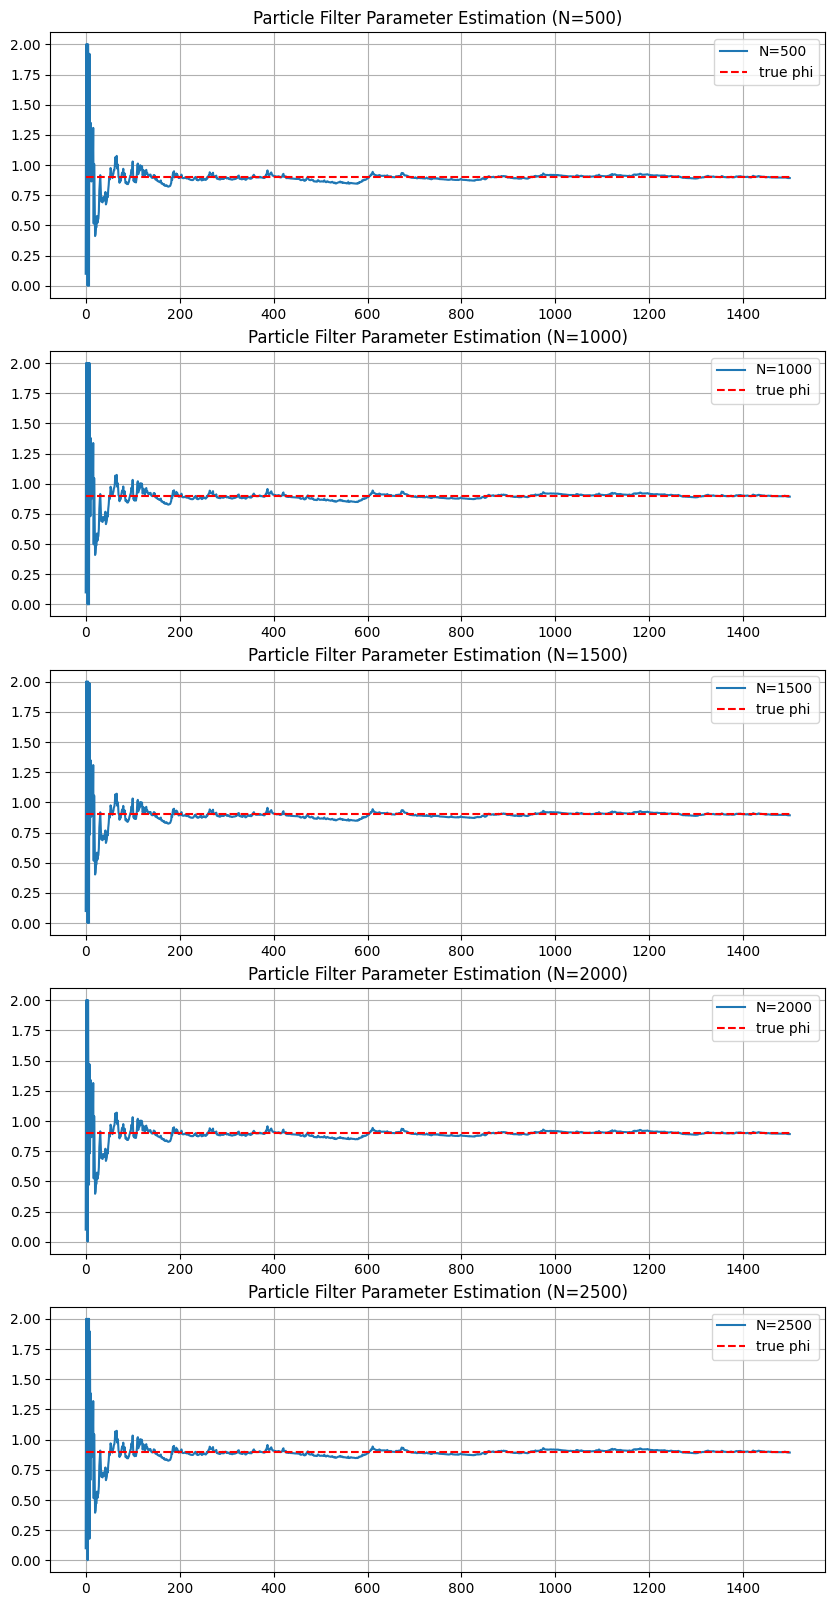

In [49]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 20))
for i, guesses in enumerate(bunch_of_guesses):
    ax[i].plot(guesses, label=f"N={(i+1)*500}")
    ax[i].hlines(y=phi, xmin=0, xmax=len(guesses), label="true phi", linestyle="dashed", color="red")
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title(f"Particle Filter Parameter Estimation (N={(i+1)*500})")

### Evaluating performance with different parameters

In [ ]:
results = {}
for phi in np.linspace(0.1, 2, 10):
    states, observations = simulate(T, phi, seed=0)
    guesses = estimate_params_vec(T=200, observations=observations, N=1000)
    results[phi] = guesses

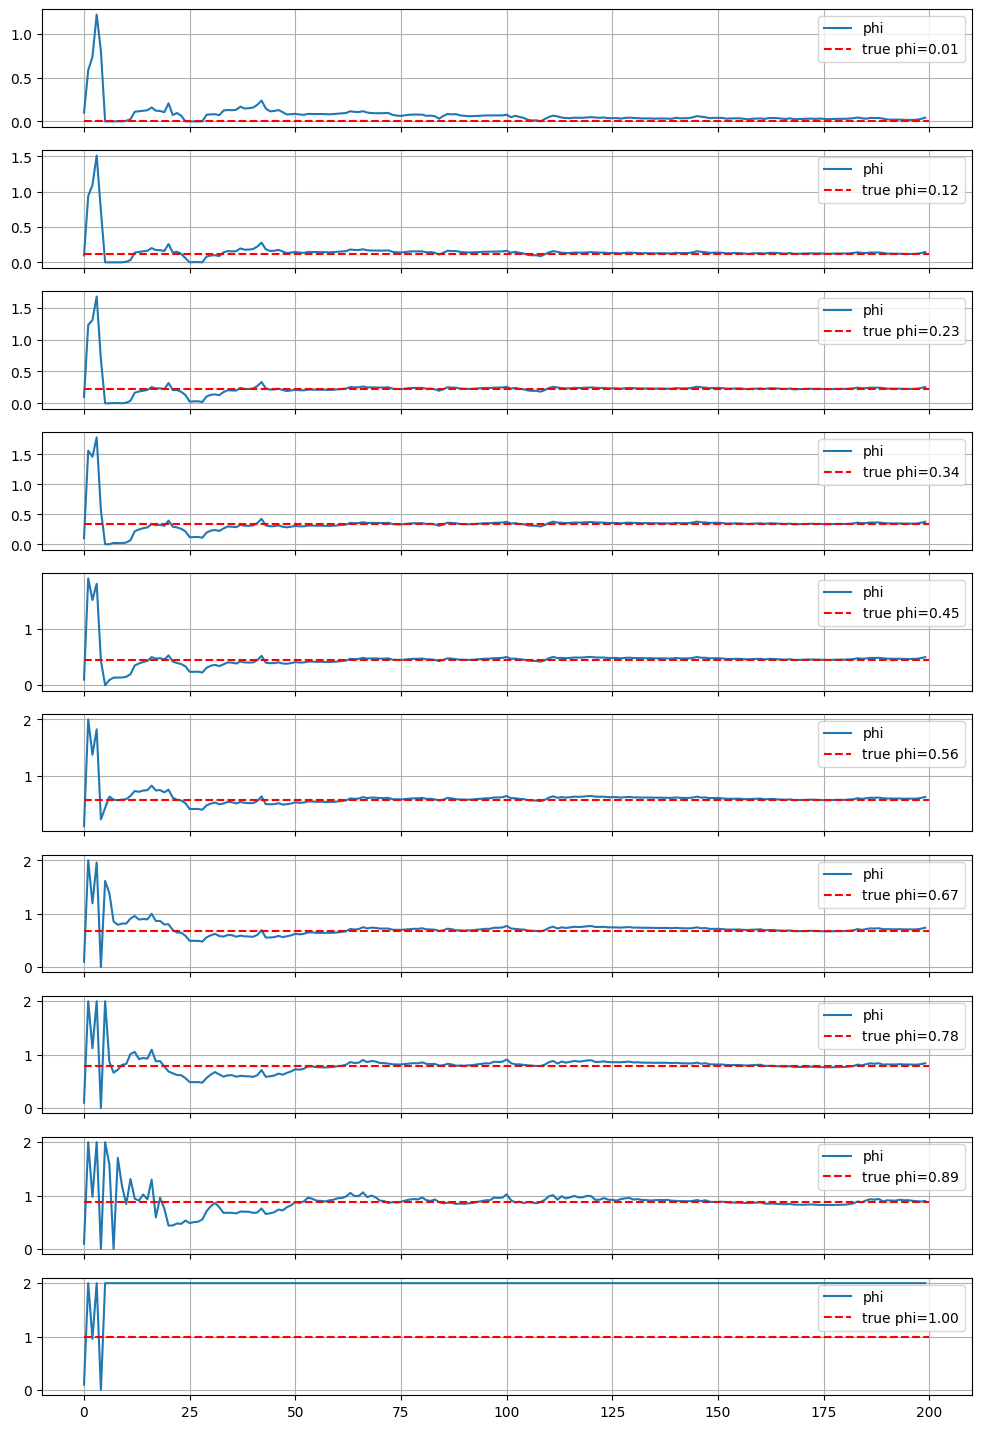

In [30]:
fig, ax = plt.subplots(figsize=(12, 18), nrows=len(results.keys()), sharex=True)
for i, items in enumerate(results.items()):
    true_phi, guesses = items
    ax[i].plot(guesses, label="phi")
    ax[i].hlines(y=true_phi, xmin=0, xmax=len(guesses), label=f"true phi={true_phi:.2f}", linestyle="dashed", color="red")
    ax[i].grid()
    ax[i].legend()

In [ ]:
results = {}
for phi in np.linspace(0.01, 1, 10):
    states, observations = simulate(T, phi, seed=0)
    guesses = estimate_params_vec(T=200, observations=observations, N=1000)
    results[phi] = guesses

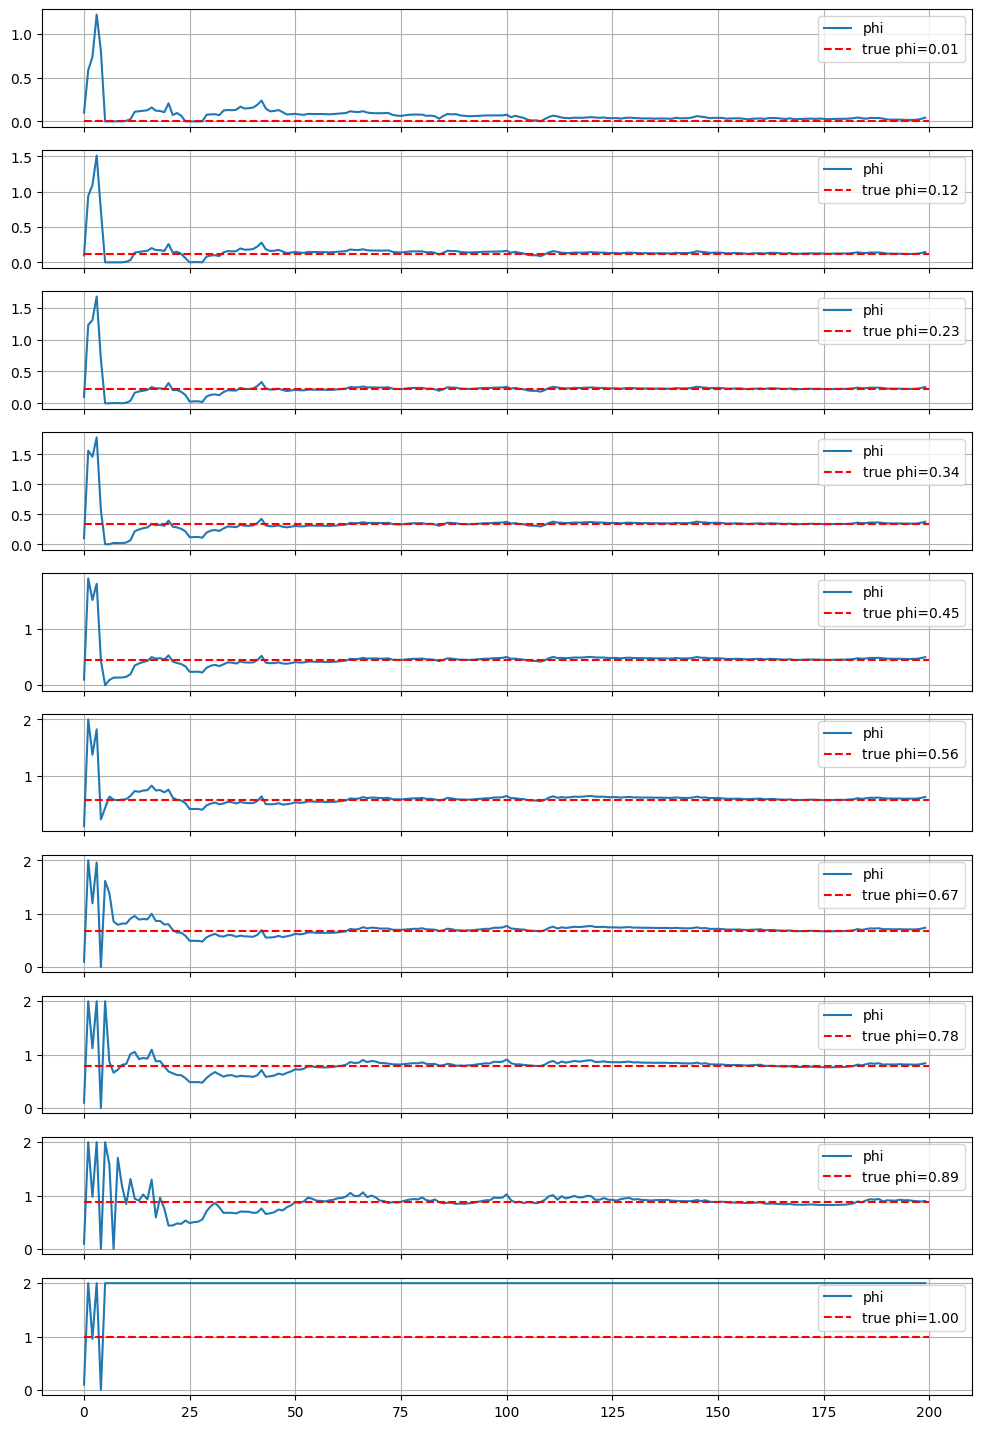

In [29]:
fig, ax = plt.subplots(figsize=(12, 18), nrows=len(results.keys()), sharex=True)
for i, items in enumerate(results.items()):
    true_phi, guesses = items
    ax[i].plot(guesses, label="phi")
    ax[i].hlines(y=true_phi, xmin=0, xmax=len(guesses), label=f"true phi={true_phi:.2f}", linestyle="dashed", color="red")
    ax[i].grid()
    ax[i].legend()